In [1]:
import emcee
import matplotlib
import numpy as np
import corner
import scipy.optimize as op

%matplotlib inline  

In [2]:
# some important variables
g = 6.6743e-8
msun = 1.989e33
au = 1.496e13
pi = 3.14159

In [3]:
name = ['GJ1005','GJ22','GJ65','GJ1081','GJ234','G250-029','G193-027','GJ469','GJ473',
       'GJ623','GJ748','GJ1245','GJ791.2','GJ831','Gl747','GJ2005']
sma = np.array([0.3037,0.5106,2.0458,0.2712,1.0932,0.4417,0.1564,0.3139,0.9167,
                0.2397,0.148,0.8267,0.1037,0.1448,0.2941,0.4619])
esma = np.array([0.0005,0.0007,0.0066,0.0027,0.0007,0.0009,0.0008,0.0008,0.0017,
                0.0014,0.0004,0.0008,0.0005,0.0005,0.0011,0.0006])
per = np.array([1666.1,5694.2,9612,4066.1,6070.1,4946.3,1195.5,4223,5772.3,
                  1367.4,901.7,6147,538.6,704.9,2102.151,17.3131*365.2422])
eper = np.array([2.5,14.9,12,27.5,10.2,2.2,1.4,2.9,9.4,
                 0.6,0.3,17,0.1,0.5,0.328,0.0097*365.2422])
per *= 24*3600.0
eper *= 24*3600.0
k = np.array([6.39, 6.04, 5.33, 7.34, 5.49, 6.35, 7.78, 6.96, 6.04, 
             5.92, 6.29, 6.85, 7.31, 6.38,  6.416,  8.241])
delk = np.array([1.23, 1.93, 0.16, 0.96, 1.58, 1.03, 0.10, 1.01, 0.00, 
                 2.87, 1.09, 1.05, 1.28, 1.20, 0.113,0.313])
## probably fix these later...
ek = np.array([  0.02, 0.02, 0.02, 0.02, 0.04, 0.02, 0.02, 0.04, 0.02,
                 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02])
edelk = np.array([  0.02, 0.03, 0.02, 0.01, 0.02, 0.07, 0.02, 0.02, 0.01,
                 0.14, 0.07, 0.01, 0.10, 0.01, 0.03, 0.01])
fluxratio = 10.0**(delk/2.5)
del_eps = 2.5*np.log10(1.0+1.0/fluxratio)
kp = del_eps+k
ks = kp + delk

# compute MC errors on Kp, Ks
mcsize = 50000
ekp = kp*0.
eks = ks*0.
for i in range(0,len(ks)):
    ktmp = k[i]+ek[i]*np.random.standard_normal(mcsize)
    deltmp = delk[i]+edelk[i]*np.random.standard_normal(mcsize)
    fluxratio = 10.0**(deltmp/2.5)
    del_eps = 2.5*np.log10(1.0+1.0/fluxratio)
    kpt = del_eps+ktmp
    kst = kp[i] + ktmp
    ekp[i] = np.std(kpt)
    eks[i] = np.std(kst)
    
plxval = np.array([166.6,99.2,373.7,65.2,241.0,95.6,112.6,76.4,235.5,
                  125.0,98.4,219.9,113.4,125.3,122.3,128.49])
plxprior = np.array([0.3,0.6,2.7,0.4,0.4,0.3,1.4,0.5,2.9,
                    0.3,0.3,0.5,0.2,0.3,2.5,1.5])

# benedict fit value
result1 = np.array([0.2311,-0.1352, 0.0400, 0.0038, -0.0032])
result2 = plxval
result = np.concatenate([result1,result2])

In [4]:
## this is mostly for checking things are reasonable
au = 1.496e13
msun = 1.989e33
g = 6.6743e-8 
empsma = sma*(1000.0/plxval)*au
empmass = (4.0*np.pi**2.*(empsma**3./per**2.)/g)/msun
#e_empmass = empmass*np.sqrt(3.0*(esma/empsma)**2. + 2.0*(eper/per)**2.)
e_empmass = np.sqrt((esma*((12.0*np.pi**2*(empsma**2/per**2)/g)/msun))**2 + 
            (eper*(6.0*np.pi**2*empsma**3/per**3)/g/msun)**2)
mka = kp - 5.0*(np.log10(1000.0/plxval)-1.)
mkb = ks - 5.0*(np.log10(1000.0/plxval)-1.)
a, b, c, d, e = result1
mass1 = a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4
mass2 = a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4
mka_err = 0.02## for now
mkb_err = 0.02## for now
mass1_err = np.sqrt((b*mka_err)**2+(2*c*mka_err*(mka-7.5))**2+(3*d*mka_err*(mka-7.5)**2)**2+
                    (4*e*mka_err*(mka-7.5)**3)**2)
mass2_err = np.sqrt((b*mkb_err)**2+(2*c*mkb_err*(mkb-7.5))**2+(3*d*mkb_err*(mkb-7.5)**2)**2+
                   (4*e*mkb_err*(mkb-7.5)**3)**2)    
model_err = np.sqrt(mass1_err**2+mass2_err**2)
model = mass1+mass2

mk1_tmp = mka[0] + mka_err*np.random.standard_normal(50000)#mka[0]+mka_err[0]*
mass1_tmp = a + b*(mk1_tmp-7.5) + c*(mk1_tmp-7.5)**2 + d*(mk1_tmp-7.5)**3 + e*(mk1_tmp-7.5)**4
mk2_tmp = mkb[0] + mkb_err*np.random.standard_normal(50000)#mka[0]+mka_err[0]*
mass2_tmp = a + b*(mk2_tmp-7.5) + c*(mk2_tmp-7.5)**2 + d*(mk2_tmp-7.5)**3 + e*(mk2_tmp-7.5)**4
#print np.std(mass1_tmp+mass2_tmp),model_err[0]

for i in range(0,len(empmass)):
    print "{:10s}".format(name[i]), \
    "{0:.3f}".format(empmass[i]),"{0:.3f}".format(e_empmass[i]), \
    "{0:.4f}".format(model[i]),"{0:.4f}".format(model_err[i]),"{0:.3f}".format(100*model_err[i]/model[i]), \
    "{0:.4f}".format(mka[i]),"{0:.4f}".format(mkb[i]), \
    "{0:.3f}".format(ekp[i]),"{0:.3f}".format(eks[i]), \
    "{0:.3f}".format(mass1[i]),"{0:.3f}".format(mass2[i])
    


GJ1005     0.291 0.001 0.3080 0.0047 1.523 7.8015 9.0315 0.021 0.020 0.194 0.114
GJ22       0.561 0.002 0.6214 0.0045 0.728 6.1921 8.1221 0.020 0.020 0.458 0.163
GJ65       0.237 0.000 0.2335 0.0052 2.230 8.8681 9.0281 0.022 0.020 0.120 0.114
GJ1081     0.581 0.006 0.5459 0.0040 0.735 6.7866 7.7466 0.020 0.020 0.346 0.200
GJ234      0.338 0.001 0.3231 0.0049 1.523 7.6278 9.2078 0.040 0.040 0.214 0.109
G250-029   0.538 0.000 0.5921 0.0041 0.692 6.6077 7.6377 0.028 0.020 0.379 0.213
G193-027   0.250 0.000 0.2451 0.0049 2.002 8.7414 8.8414 0.022 0.020 0.125 0.121
GJ469      0.519 0.001 0.5551 0.0040 0.727 6.7365 7.7465 0.040 0.040 0.355 0.200
GJ473      0.236 0.001 0.2572 0.0047 1.820 8.6525 8.6525 0.021 0.020 0.129 0.129
GJ623      0.503 0.000 0.5078 0.0054 1.068 6.4791 9.3491 0.022 0.020 0.403 0.104
GJ748      0.558 0.000 0.5891 0.0041 0.698 6.5939 7.6839 0.027 0.020 0.381 0.208
GJ1245     0.188 0.001 0.1979 0.0072 3.659 8.9110 9.9610 0.020 0.020 0.118 0.080
GJ791.2    0.352 0.000 0.296

In [5]:
def lnlike(theta, sma, per, esma, eper, kp, ks, ekp, eks):
    au = 1.496e13
    msun = 1.989e33
    g = 6.6743e-8 
    a, b, c, d, e = theta[0:5]
    mplx = theta[5:theta.size]
    factor = ((4.0*np.pi**2.)/(g*msun))*(au*1000.0/mplx)**3
    empmass = factor*(empsma**3./per**2.)
    #e_empmass = empmass*np.sqrt(3.0*(esma/empsma)**2. + 2.0*(eper/per)**2.)
    e_empmass = np.sqrt((esma*((12.0*np.pi**2*(empsma**2/per**2)/g)/msun))**2 + 
            (eper*(6.0*np.pi**2*empsma**3/per**3)/g/msun)**2)

    mka = kp - 5.0*(np.log10(1000.0/mplx)-1.)
    mkb = ks - 5.0*(np.log10(1000.0/mplx)-1.)
    mass1 = a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4
    mass2 = a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4
    mka_err = ekp
    mkb_err = eks
    mass1_err = np.sqrt((b*mka_err)**2+(2*c*mka_err*(mka-7.5))**2+(3*d*mka_err*(mka-7.5)**2)**2+
                       (4*e*mka_err*(mka-7.5)**3)**2)
    mass2_err = np.sqrt((b*mkb_err)**2+(2*c*mkb_err*(mkb-7.5))**2+(3*d*mkb_err*(mkb-7.5)**2)**2+
                       (4*e*mkb_err*(mkb-7.5)**3)**2)    
    model_err = np.sqrt(mass1_err**2+mass2_err**2)
    #print model_err[0],e_empmass[0],mka[0],mkb[0]
    if np.min(mass1) <= 0:
        return -np.inf
    if np.min(mass2) <= 0:
        return -np.inf
    model = mass1+mass2
    inv_sigma2 = 1.0/np.sqrt(e_empmass**2+model_err**2)
    #print empmass[0],model[0],e_empmass[0],inv_sigma2[0]
    return -0.5*(np.sum((empmass-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [6]:
def lnprior(theta, plxval, plxprior):
    mplx = theta[5:theta.size]
    lp = 0
    if np.min(mplx) <= 0:
        return -np.inf
    for i in range(0,len(mplx)):
        lp += ((np.float(mplx[i])-np.float(plxval[i]))**2)/(np.float(plxprior[i])**2)
    lp*=(-0.5)
    if not np.isfinite(lp):
        return 0.0
    return lp

In [7]:
def lnprob(theta, plxval, plxprior, sma, per, esma, eper, kp, ks, ekp, eks):
    lp = lnprior(theta, plxval, plxprior)
    if not np.isfinite(lp):
        return -np.inf
    like = lnlike(theta, sma, per, esma, eper, kp, ks, ekp, eks)
    val = lp + like
    return val

In [8]:
ndim, nwalkers = result.size, 100
pos = [result + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(plxval, plxprior, sma, per, esma, eper, kp, ks, ekp, eks),
                               threads=3)
## burn-in and/or testing
pos, prob, state = sampler.run_mcmc(pos, 5000)
sampler.reset()

/Users/andrewmann/anaconda/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/andrewmann/anaconda/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


In [9]:
nsteps = 100000
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    if (i+1) % 5000 == 0:
        print("{0:5.1%}".format(float(i) / nsteps))

 5.0%
10.0%
15.0%
20.0%
25.0%
30.0%
35.0%
40.0%
45.0%
50.0%
55.0%
60.0%
65.0%
70.0%
75.0%
80.0%
85.0%
90.0%
95.0%
100.0%


In [10]:
dat = sampler.chain
prob = sampler.lnprobability
accept = sampler.acceptance_fraction
arr = dat.reshape((dat.shape)[0]*(dat.shape)[1],dat.shape[2])
for i in range(5,dat.shape[2]):
    print "{:10s}".format(name[i-5]), \
    "{0:.4f}".format(np.median(arr[:,i])),"{0:.4f}".format(np.std(arr[:,i])),"{0:.4f}".format(plxprior[i-5]), \
    "{0:.4f}".format(plxval[i-5]),"{0:.4f}".format((plxval[i-5]-np.median(arr[:,i]))/plxprior[i-5]), \
    "{0:.4f}".format((plxval[i-5]-np.median(arr[:,i]))/np.sqrt(plxprior[i-5]**2+np.std(arr[:,i])**2))
    

GJ1005     4028.9504 5670.0626 0.3000 166.6000 -12874.5013 -0.6812
GJ22       162.6010 4.1843 0.6000 99.2000 -105.6683 -14.9988
GJ65       134.9047 20.9293 2.7000 373.7000 88.4427 11.3159
GJ1081     149.4598 3.6859 0.4000 65.2000 -210.6494 -22.7266
GJ234      10776.1959 33649.7932 0.4000 241.0000 -26337.9897 -0.3131
G250-029   163.7679 15.2557 0.3000 95.6000 -227.2264 -4.4675
G193-027   113.9831 5.3079 1.4000 112.6000 -0.9879 -0.2520
GJ469      143.2732 9.2613 0.5000 76.4000 -133.7465 -7.2102
GJ473      1156.6809 496.3414 2.9000 235.5000 -317.6486 -1.8559
GJ623      151.6066 8.8029 0.3000 125.0000 -88.6886 -3.0207
GJ748      11402.1906 3986.0807 0.3000 98.4000 -37679.3019 -2.8358
GJ1245     125.9324 7.7097 0.5000 219.9000 187.9351 12.1627
GJ791.2    114.0891 4.1750 0.2000 113.4000 -3.4456 -0.1649
GJ831      1404.9666 1054.1460 0.3000 125.3000 -4265.5553 -1.2139
Gl747      179.2137 26.7757 2.5000 122.3000 -22.7655 -2.1164
GJ2005     100.9592 2.6237 1.5000 128.4900 18.3539 9.1095


In [11]:
sma_au = sma*au*(1000/plxval)
mass = (4.*(pi**2.))*((sma_au**3./per**2.)/g)/msun

mka = kp - 5.0*(np.log10(1000.0/plxval)-1.)
mkb = ks - 5.0*(np.log10(1000.0/plxval)-1.)

a = np.median(arr[:,0])
b = np.median(arr[:,1])
c = np.median(arr[:,2])
d = np.median(arr[:,3])
e = np.median(arr[:,4])
mass1 = a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4
mass2 = a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4
sysmass = mass1+mass2
a, b, c, d, e = result1
mass1 = a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4
mass2 = a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4
sysmass_ben = mass1+mass2

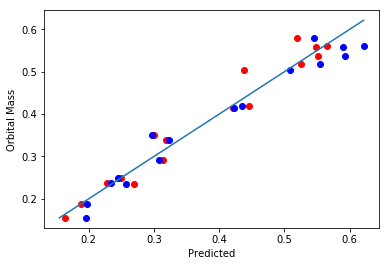

In [12]:
import matplotlib.pyplot as plt

rng = [np.min(np.concatenate([sysmass,sysmass_ben,mass])),
         np.max(np.concatenate([sysmass,sysmass_ben,mass]))]
plt.figure()
plt.plot(sysmass,mass,'ro')
plt.ylabel('Orbital Mass')
plt.xlabel('Predicted')
plt.plot(sysmass_ben,mass,'ro',color='b')
plt.plot(rng,rng)

(10000000,) (10000000,)


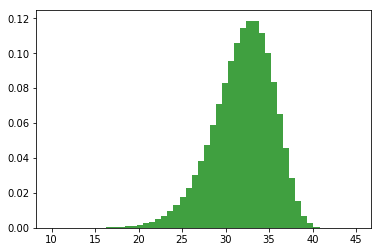

In [21]:
#num = 7
#plt.plot(dat[2,:,num])
#print np.median(arr[:,num]),plxval[num-5]
newprob = prob.reshape((prob.shape)[0]*(dat.shape)[1])
print newprob.shape,arr[:,0].shape
n, bins, patches = plt.hist(newprob[np.isfinite(newprob)], 50, range=[10,45],normed=1, facecolor='green', alpha=0.75)
plt.show()

0.233474154482 -0.0954944219913 0.00994441961173 -0.00253920815533 0.00165951681154
[6.1921355904651003, 9.9609728630480259]


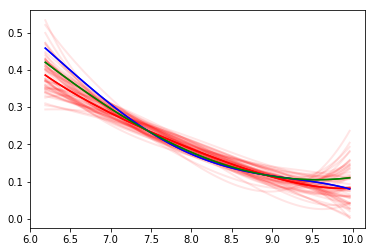

In [25]:
a = np.median(arr[np.isfinite(newprob),0])
b = np.median(arr[np.isfinite(newprob),1])
c = np.median(arr[np.isfinite(newprob),2])
d = np.median(arr[np.isfinite(newprob),3])
e = np.median(arr[np.isfinite(newprob),4])
print np.median(a),np.median(b),np.median(c),np.median(d),np.median(e)

rng = [np.min(np.concatenate([mka,mkb])),np.max(np.concatenate([mka,mkb]))]
print rng
mk = np.linspace(rng[0],rng[1],100)
mass1 = a + b*(mk-7.5) + c*(mk-7.5)**2 + d*(mk-7.5)**3 + e*(mk-7.5)**4 ## new fit
a, b, c, d, e = result1
mass2 = a + b*(mk-7.5) + c*(mk-7.5)**2 + d*(mk-7.5)**3 + e*(mk-7.5)**4

mass3 = 0.585825902+3.87151019e-1*mk-1.21729937e-1*mk**2.+1.05529583e-2*mk**3.-2.72615872e-4*mk**4.

## red = new fit
## blue = Benedict
## green = How to constrain your M dwarf
plt.plot(mk,mass1,color='r')
plt.plot(mk,mass2,color='b')
plt.plot(mk,mass3,color='g')


for i in range(0,60):
    index = np.random.randint(len(arr[:,0]))
    if np.isfinite(newprob[index]):
        a, b, c, d, e = arr[index,0:5]
        mass = a + b*(mk-7.5) + c*(mk-7.5)**2 + d*(mk-7.5)**3 + e*(mk-7.5)**4
        plt.plot(mk,mass,color='r',lw=2,alpha=0.1)
#    pl.plot(xl, m*xl+b, color="k", alpha=0.1)
#pl.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
#pl.errorbar(x, y, yerr=yerr, fmt=".k")

plt.plot(mk,mass1,color='r')
plt.plot(mk,mass2,color='b')
plt.plot(mk,mass3,color='g')

plt.show()
